In [2]:
using CairoMakie
include("DenseNTK.jl")
include("FastNTKMethods.jl")

kernel (generic function with 3 methods)

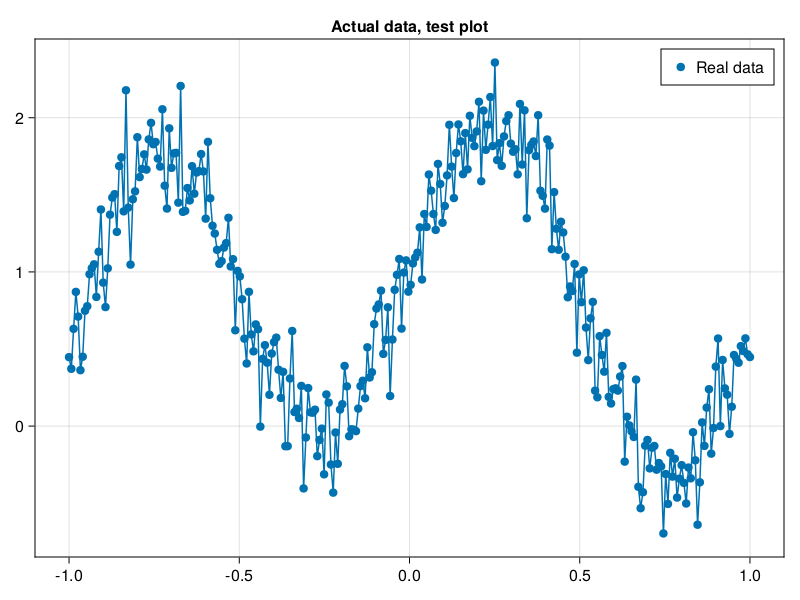

In [4]:
Nx=300
a=-1.0; b=1.0

xVec=collect(range(a,stop=b,length=Nx));
yVec=sin.(2*pi*xVec) + cos.(xVec) + 0.2*randn(size(xVec)); 

fig = Figure()
ax1 = Axis(fig[1,1],title="Actual data, test plot")

CairoMakie.lines!(xVec[:], yVec[:])
CairoMakie.scatter!(xVec[:], yVec[:], label="Real data")

axislegend(ax1,position=:rt)
fig

In [27]:
# GAGNAÖFLUN
using Flux

noMod = 2
noLh1 = [100, 1000, 10_000, 50_000]
Lh1 = [Vector{Any}() for _ in 1:length(noLh1)]
Kh1 = [Vector{Any}() for _ in 1:length(noLh1)]
Eh1 = [Vector{Any}() for _ in 1:length(noLh1)]

@time "Creating $(length(noLh1)*noMod) models" for i in 1:noMod
    for j in 1:length(Lh1)
        m = Chain(DenseNTK(1, noLh1[j], elu), DenseNTK(noLh1[j], 1))
        push!(Lh1[j], m) 
    end
end

@time "Computing $(length(noLh1)*noMod) Kernels" for i in 1:length(Lh1)
    @showprogress desc="Kernels ($(noLh1[i]) nodes)"for j in 1:noMod
        K = kernel(Lh1[i][j], hcat(xVec...), false, 4)
        push!(Kh1[i], K) 
    end
end

@time "Computing $(length(noLh1)*noMod*length(xVec)) eigenvalues" for i in 1:length(Lh1)
    @showprogress desc="Eigenvalues ($(noLh1[i]) nodes)"for j in 1:noMod
        E = eigen(Kh1[i][j])
        push!(Eh1[i], E) 
    end
end 


Creating 8 models: 0.002092 seconds (105 allocations: 1.403 MiB)
Computing 8 Kernels: 7.692050 seconds (9.86 M allocations: 11.071 GiB, 6.77% gc time, 32.72% compilation time)
Computing 2400 eigenvalues: 0.107391 seconds (192 allocations: 17.351 MiB)


In [28]:
# Getting means and standard deviation
using Statistics

mean_eig = zeros(length(xVec), length(noLh1))
std_eig = zeros(length(xVec), length(noLh1))



@time for i = 1:length(noLh1)
    current_eigs = zeros(length(xVec), noMod)

    for j = 1:noMod
        current_eigs[:, j] .= Eh1[i][j].values
    end

    current_mean = current_eigs * ones(noMod,1) * 1/noMod
    mean_eig[:,i] .= current_mean

    for j = 1:size(current_eigs, 1)
        current_std = std(current_eigs[j,:])
        std_eig[j,i] = current_std
    end
end

display(mean_eig)
display(std_eig)

300×4 Matrix{Float64}:
  -8.43334e-14    1.88751e-15    4.6235e-10     1.59511e-9
  -2.50924e-14    3.42647e-15    6.45014e-10    1.83562e-9
  -2.84642e-15    2.65005e-14    8.71981e-10    1.94016e-9
  -1.41793e-15    6.98709e-14    9.12834e-10    1.97797e-9
  -1.09131e-15    2.21872e-13    9.42719e-10    2.0566e-9
  -1.01059e-15    2.29341e-13    1.0696e-9      2.09189e-9
  -9.04627e-16    4.78205e-13    1.15046e-9     2.16832e-9
  -7.2044e-16     6.64216e-13    1.20625e-9     2.19423e-9
  -7.04075e-16    8.22644e-13    1.33988e-9     2.23705e-9
  -6.0068e-16     9.02757e-13    1.37447e-9     2.25712e-9
   ⋮                                          
   0.00179554     0.00449357     0.00391901     0.00395059
   0.00367429     0.00709061     0.00711357     0.0069542
   0.0106382      0.0138605      0.0144626      0.0143531
   0.0296279      0.0300331      0.0320705      0.0311415
   0.0859901      0.0903588      0.095941       0.0965601
   0.292813       0.359323       0.348107       0.

300×4 Matrix{Float64}:
  3.46441e-14   6.84301e-16  3.88064e-10  2.34299e-10
  1.0769e-14    1.69919e-15  3.16471e-10  7.54641e-11
  2.69141e-16   3.39224e-14  1.26875e-10  3.3265e-11
  1.25629e-16   8.80803e-14  7.66986e-11  1.79424e-11
  2.31491e-16   3.02049e-13  5.23592e-11  6.0925e-11
  3.04703e-16   3.11659e-13  6.42174e-11  3.31553e-11
  1.67101e-16   6.00197e-13  1.33473e-10  2.83446e-11
  8.45984e-17   7.49853e-13  1.09256e-10  3.84365e-11
  6.52773e-17   6.3782e-13   7.13078e-11  6.53875e-11
  6.19057e-17   5.77518e-13  8.17692e-11  4.67432e-11
  ⋮                                       
  0.000242854   0.00101188   2.92098e-5   1.95232e-5
  3.35093e-5    0.000634781  0.000275352  2.14313e-5
  0.00441355    0.000225742  0.00076277   9.12645e-5
  0.000952998   0.00375255   0.000969817  0.00029611
  0.00183547    0.0091661    0.00265249   0.000867091
  0.0692271     0.019048     0.0139324    0.00307809
  0.041563      0.0403416    0.00706498   0.0197305
 12.0669       11.5972   

  0.000498 seconds (4.89 k allocations: 210.656 KiB)


In [29]:
using CairoMakie, ColorSchemes

# Create figure and axis
fig = Figure()

# Subplot 1
main_axis = Axis(fig[1, 1], title="Mean eigenvalues of one hidden layer", yscale=log10)

# Loop through your data (assuming Eh1, noLh1 are defined elsewhere)
for i = 1:size(mean_eig,2)
    CairoMakie.scatter!(main_axis, abs.(mean_eig[:,i]), label="$(noLh1[i]) nodes")
    CairoMakie.lines!(main_axis, abs.(mean_eig[:,i]))
end

# Add legend to the axis
axislegend(main_axis, position=:lt)


# Subplot 1
sub_axis = [
    Axis(fig[1, 2][1,1], title="$(noLh1[1]) nodes", yscale=log10),
    Axis(fig[1, 2][1,2], title="$(noLh1[2]) nodes", yscale=log10),
    Axis(fig[1, 2][2,1], title="$(noLh1[3]) nodes", yscale=log10),
    Axis(fig[1, 2][2,2], title="$(noLh1[4]) nodes", yscale=log10)
]

for i = 1:length(sub_axis)
    for j = 1:noMod
        CairoMakie.lines!(sub_axis[i], abs.(Eh1[i][j].values), color=:gray, linewidth=0.4)
    end
end

In [30]:
std_fig = Figure()

# Subplot 1
subb_axis = [
    Axis(std_fig[1,1], title="$(noLh1[1]) nodes", yscale=log10),
    Axis(std_fig[1,2], title="$(noLh1[2]) nodes", yscale=log10),
    Axis(std_fig[2,1], title="$(noLh1[3]) nodes", yscale=log10),
    Axis(std_fig[2,2], title="$(noLh1[4]) nodes", yscale=log10)
]

for i = 1:length(subb_axis)
    CairoMakie.lines!(subb_axis[i], abs.(std_eig[:,i])[:], color=:red, linewidth=1)
end

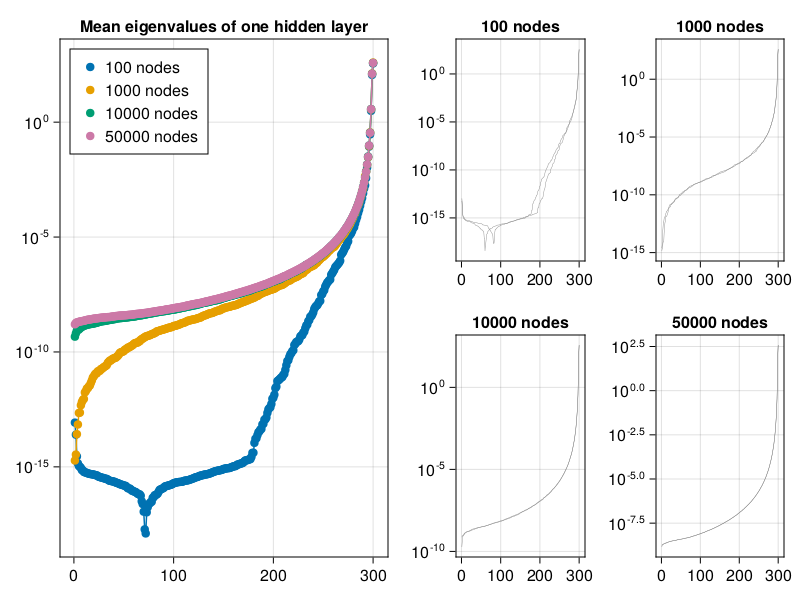

CairoMakie.Screen{IMAGE}


In [31]:
display(fig)
#display(std_fig)